In [112]:
import pandas as pd
import numpy as np
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as sm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math
import graphviz

In [14]:
data = pd.read_csv('Pokemon.csv')
data['Type 2']=data['Type 2'].replace('NaN', 'no')
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [3]:
legendaries = data[data['Legendary']==True]
commons = data[data['Legendary']==False]

## Legendaries

In [9]:
print('number :', len(legendaries))
print('average total stats :', np.mean(legendaries['Total']))
for stat in ['HP', 'Attack','Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print('average', stat, ':', np.mean(legendaries[stat]))
print('Number of legendaries per type :', Counter(legendaries['Type 1']))
print('Number of legendaries per generation :', Counter(legendaries['Generation']))
#print('IDs :', list(legendaries['#']))

number : 75
average total stats : 630.2666666666667
average HP : 93.08
average Attack : 113.37333333333333
average Defense : 98.93333333333334
average Sp. Atk : 119.73333333333333
average Sp. Def : 105.01333333333334
average Speed : 100.13333333333334
Number of legendaries per type : Counter({'Psychic': 17, 'Dragon': 12, 'Water': 8, 'Fire': 5, 'Electric': 4, 'Rock': 4, 'Steel': 4, 'Ground': 4, 'Normal': 4, 'Grass': 3, 'Ice': 2, 'Ghost': 2, 'Dark': 2, 'Flying': 2, 'Bug': 1, 'Fairy': 1})
Number of legendaries per generation : Counter({5: 20, 3: 18, 4: 16, 6: 8, 1: 7, 2: 6})


## Non-legendaries

In [8]:
print('number :', len(commons))
print('average stats :', np.mean(commons['Total']))
for stat in ['HP', 'Attack','Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print('average', stat, ':', np.mean(commons[stat]))
print('Number of non-legendaries per type :', Counter(commons['Type 1']))
print('Number of non-legendaries per generation :', Counter(commons['Generation']))
#print('IDs :', list(commons['#']))

number : 725
average stats : 414.9131034482759
average HP : 66.79448275862069
average Attack : 75.4455172413793
average Defense : 71.24689655172413
average Sp. Atk : 67.96689655172413
average Sp. Def : 68.47724137931034
average Speed : 64.98206896551724
Number of non-legendaries per type : Counter({'Water': 104, 'Normal': 94, 'Bug': 68, 'Grass': 67, 'Fire': 47, 'Electric': 40, 'Psychic': 40, 'Rock': 40, 'Ghost': 30, 'Dark': 29, 'Poison': 28, 'Ground': 28, 'Fighting': 27, 'Steel': 23, 'Ice': 22, 'Dragon': 20, 'Fairy': 16, 'Flying': 2})
Number of non-legendaries per generation : Counter({1: 159, 5: 145, 3: 142, 4: 105, 2: 100, 6: 74})


In [17]:
def correlation_columns(data, class_to_predict):
    n = np.shape(data)[1]
    dict_corr = {}
    for feature in data.columns:
        if feature==class_to_predict:
            continue
        corr, pval = spearmanr(data[feature], data[class_to_predict])
        dict_corr[feature]= corr, pval
    return dict_corr

In [111]:
corr_pval = correlation_columns(data, 'Defense')
dict(sorted(corr_pval.items(), key=lambda x:x[1], reverse=True))

{'Type 2': (nan, nan),
 'Total': (0.6818641809814782, 1.7761307077750298e-110),
 'Sp. Def': (0.5788164910445328, 9.67370266103567e-73),
 'Attack': (0.5149946056788183, 2.1597981316449784e-55),
 'HP': (0.433401747319042, 5.744027179753025e-38),
 'Sp. Atk': (0.31421702523225425, 8.618117974741995e-20),
 'Legendary': (0.29099604717222644, 4.457456275161717e-17),
 '#': (0.11744373856339439, 0.0008742776305834208),
 'Speed': (0.09281775844217616, 0.008617925255959499),
 'Type 1': (0.08814145729136508, 0.012632174650459651),
 'Generation': (0.057776100452835426, 0.10247658852236204),
 'Name': (-0.023232001878090134, 0.5117203174792913)}

In [106]:
threshold_leg = [144, 243, 377, 480, 638, 716]
count=0
for gen in range(1, 7):
    print(gen)
    data_i = data[data['Generation']==gen]
    list_id = []
    for i in range(len(data_i['#'])):
        if data_i['#'][i+count]<threshold_leg[gen-1]:
            list_id.append(0)
        else:
            list_id.append(1)
    count+=len(data_i['#'])
    print(spearmanr(list_id, data_i['Legendary']))

1
SpearmanrResult(correlation=0.82872942075818, pvalue=3.4080041766115255e-43)
2
SpearmanrResult(correlation=0.7589466384404111, pvalue=4.287719687643134e-21)
3
SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)
4
SpearmanrResult(correlation=1.0, pvalue=0.0)
5
SpearmanrResult(correlation=0.9713357558974813, pvalue=1.270259215273478e-103)
6
SpearmanrResult(correlation=1.0, pvalue=0.0)


<AxesSubplot:>

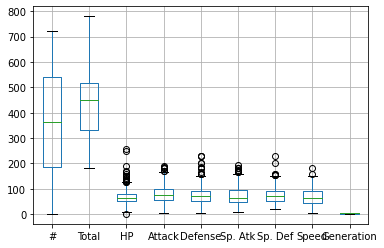

In [34]:
list_int_feature=[]
for feature in data.columns:
    if type(data[feature][0])==np.int64:
        list_int_feature.append(feature)
data.boxplot(column=list_int_feature)

# Clustering by unsupervised learning

In [107]:
def clustering_by_unsupervised_learning(data, feature1, feature2, class_to_predict):
    X = data[[feature1, feature2]]
    Y = data[class_to_predict]
    k=2
    plt.title("Two informative features, one cluster per class")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='o', c=Y, s=25, edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    # K-mean
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    plt.title("K-MEAN")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=km.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    # Hierarchical clustering
    clusterings = []
    for linkage in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=k)
        clustering.fit(X)
        clusterings.append(clustering)
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.title("Hierarchical clustering ("+linkage+")")
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=clustering.labels_)
        plt.show()

    # Spectral clustering
    spectral = cluster.SpectralClustering(n_clusters=k, eigen_solver='arpack', affinity="nearest_neighbors")
    spectral.fit(X)
    plt.title("Spectral Clustering")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=spectral.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()
    
    return km, clusterings, spectral

In [108]:
def evaluation(km, clusterings, spectral):
    # comparison of the three methods
    methods = ['K-MEAN', 'Clustering(Ward)', 'Clustering (Average)', 'Clustering (Complete)', 'Spectral Clustering']
    list_results = [km, clusterings[0], clusterings[1], clusterings[2], spectral]
    Scores_1 = [[], [], [], [], []]
    
    for result in list_results:
        Scores_1[0].append(metrics.homogeneity_score(Y, result.labels_))
        Scores_1[1].append(metrics.completeness_score(Y, result.labels_))
        Scores_1[2].append(metrics.v_measure_score(Y, result.labels_))
        Scores_1[3].append(metrics.adjusted_rand_score(Y, result.labels_))
        Scores_1[4].append(metrics.silhouette_score(X, result.labels_))
    
    for i in range(5):
        print(methods[i])
        print("Homogeneity :", Scores_1[0][i])
        print("Completeness :", Scores_1[1][i])
        print("V-measure :", Scores_1[2][i])
        print("Adjusted Rand-Index :", Scores_1[3][i])
        print("Silhouette Coefficient :", Scores_1[4][i], '\n')

## Test on stat total and each stat

HP


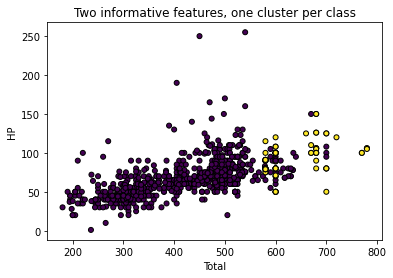

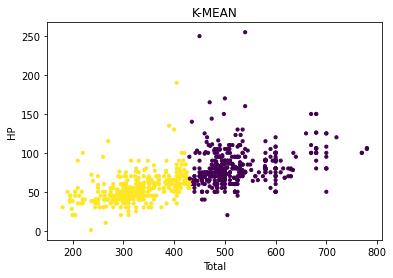

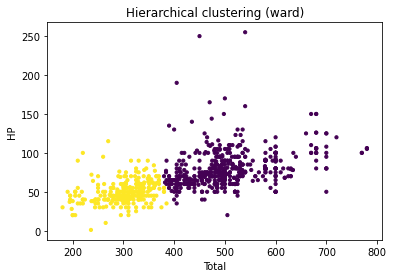

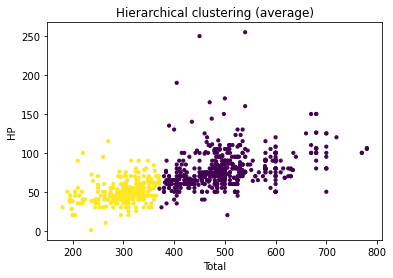

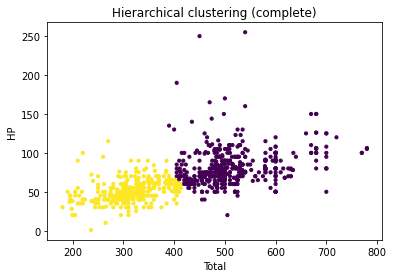

C:\Users\llego\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


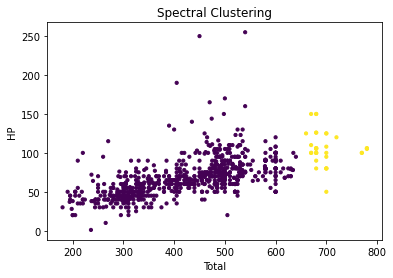

K-MEAN
Homogeneity : 0.20666011079133864
Completeness : 0.09296534483871094
V-measure : 0.1282416303629724
Adjusted Rand-Index : 0.015171959281127781
Silhouette Coefficient : 0.21724369743215965 

Clustering(Ward)
Homogeneity : 0.13870012737311277
Completeness : 0.06657284985080143
V-measure : 0.08996471799427434
Adjusted Rand-Index : -0.04963495760610946
Silhouette Coefficient : 0.21694804942823687 

Clustering (Average)
Homogeneity : 0.13434237865218812
Completeness : 0.06503678888733382
V-measure : 0.08764403048570947
Adjusted Rand-Index : -0.05313157348629689
Silhouette Coefficient : 0.21676084987680982 

Clustering (Complete)
Homogeneity : 0.1732150843323478
Completeness : 0.07936388712202075
V-measure : 0.10885326139090182
Adjusted Rand-Index : -0.018892642319885248
Silhouette Coefficient : 0.21912916254601214 

Spectral Clustering
Homogeneity : 0.2334156191592513
Completeness : 0.4224773323369503
V-measure : 0.30069787419799443
Adjusted Rand-Index : 0.4527351569069374
Silhouette

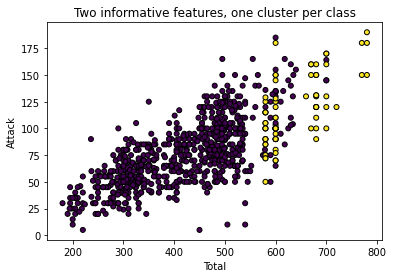

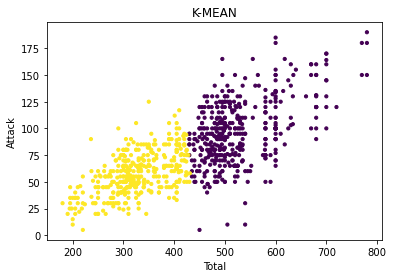

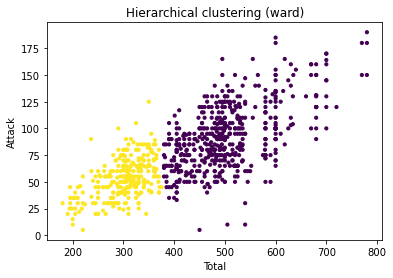

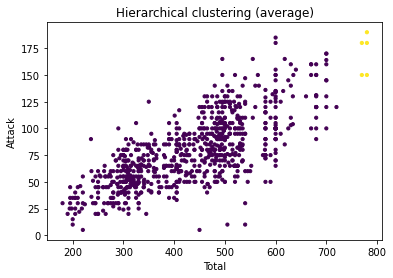

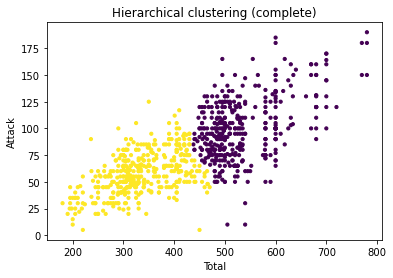

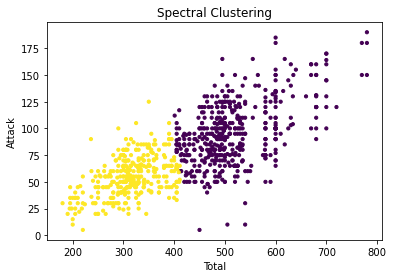

K-MEAN
Homogeneity : 0.2035317749356588
Completeness : 0.09163766659073222
V-measure : 0.12637606952619623
Adjusted Rand-Index : 0.011831561784165629
Silhouette Coefficient : 0.21644520843048365 

Clustering(Ward)
Homogeneity : 0.1355810193887003
Completeness : 0.06547174492613657
V-measure : 0.08830245083665826
Adjusted Rand-Index : -0.052147570744389395
Silhouette Coefficient : 0.21707613642810092 

Clustering (Average)
Homogeneity : 0.048173159068099165
Completeness : 0.39493991809621876
V-measure : 0.08587200187610823
Adjusted Rand-Index : 0.10346835536673302
Silhouette Coefficient : 0.25600707887701907 

Clustering (Complete)
Homogeneity : 0.22530926978008356
Completeness : 0.10113378613865794
V-measure : 0.13960400806116802
Adjusted Rand-Index : 0.035685865964282644
Silhouette Coefficient : 0.21543921699077756 

Spectral Clustering
Homogeneity : 0.16902430654829628
Completeness : 0.07774743006964206
V-measure : 0.10650494771837779
Adjusted Rand-Index : -0.022886113697504203
Silho

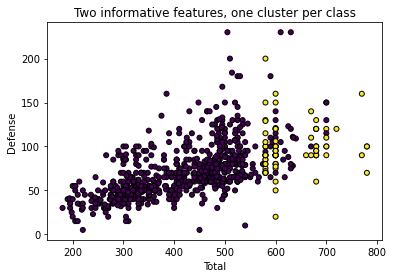

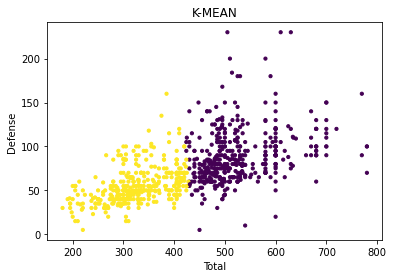

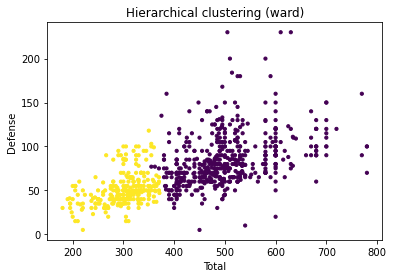

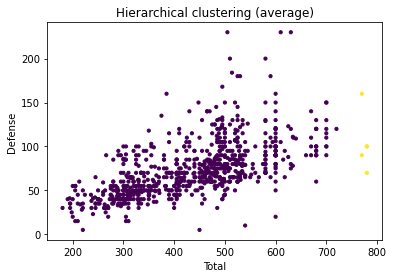

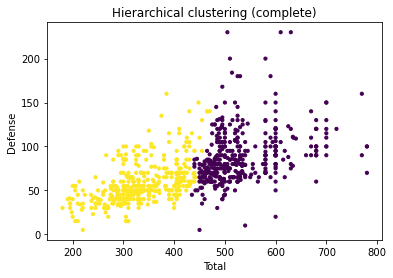

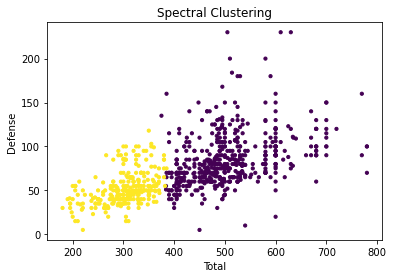

K-MEAN
Homogeneity : 0.19966662133995375
Completeness : 0.09001363975707576
V-measure : 0.12408659987217438
Adjusted Rand-Index : 0.0077461437212101945
Silhouette Coefficient : 0.21673011939012754 

Clustering(Ward)
Homogeneity : 0.13310881871407346
Completeness : 0.06460490205846495
V-measure : 0.08698923031279186
Adjusted Rand-Index : -0.05410359039815351
Silhouette Coefficient : 0.21607766486598945 

Clustering (Average)
Homogeneity : 0.048173159068099165
Completeness : 0.39493991809621876
V-measure : 0.08587200187610823
Adjusted Rand-Index : 0.10346835536673302
Silhouette Coefficient : 0.25600707887701907 

Clustering (Complete)
Homogeneity : 0.22115543022436154
Completeness : 0.09927598048357474
V-measure : 0.1370366414845766
Adjusted Rand-Index : 0.03103018597427139
Silhouette Coefficient : 0.21611078432293782 

Spectral Clustering
Homogeneity : 0.13932785013854251
Completeness : 0.06679546642778939
V-measure : 0.09030000963903762
Adjusted Rand-Index : -0.04912338823485357
Silhou

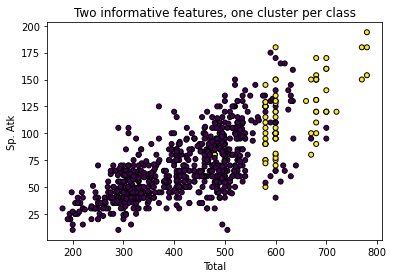

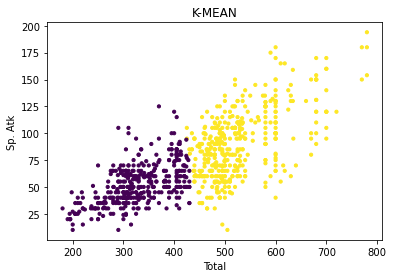

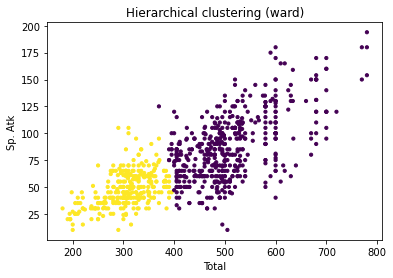

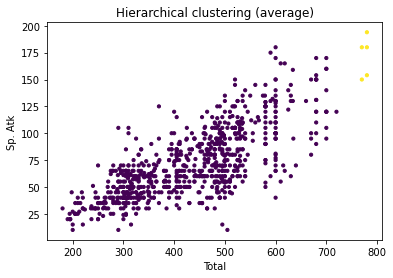

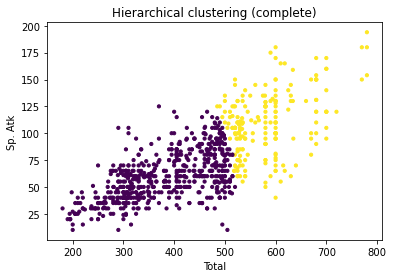

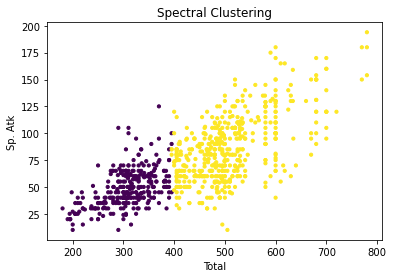

K-MEAN
Homogeneity : 0.20509187023098974
Completeness : 0.09229828639503
V-measure : 0.12730500828026395
Adjusted Rand-Index : 0.01349366958869755
Silhouette Coefficient : 0.2170731635878588 

Clustering(Ward)
Homogeneity : 0.14632069633370182
Completeness : 0.06929910046424691
V-measure : 0.09405344765007431
Adjusted Rand-Index : -0.04329551054353538
Silhouette Coefficient : 0.21745381413009324 

Clustering (Average)
Homogeneity : 0.048173159068099165
Completeness : 0.39493991809621876
V-measure : 0.08587200187610823
Adjusted Rand-Index : 0.10346835536673302
Silhouette Coefficient : 0.25600707887701907 

Clustering (Complete)
Homogeneity : 0.42286839535978354
Completeness : 0.22855102879796538
V-measure : 0.2967274331144878
Adjusted Rand-Index : 0.33269250675218814
Silhouette Coefficient : 0.17613292421737167 

Spectral Clustering
Homogeneity : 0.15020465236754418
Completeness : 0.0707089353872466
V-measure : 0.09615353376008165
Adjusted Rand-Index : -0.03996010250042213
Silhouette Co

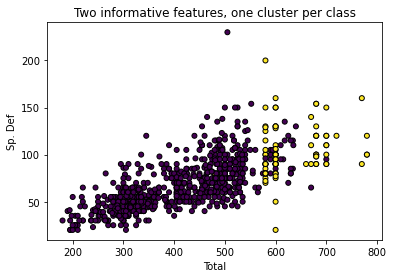

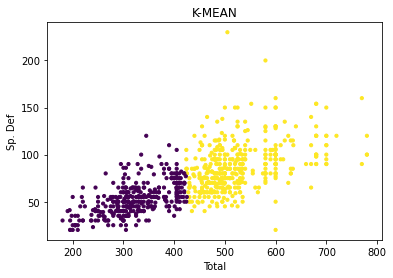

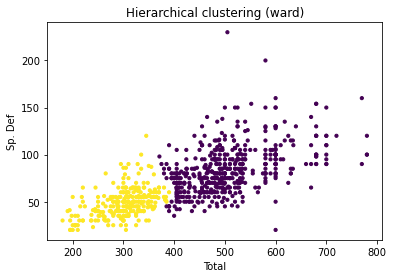

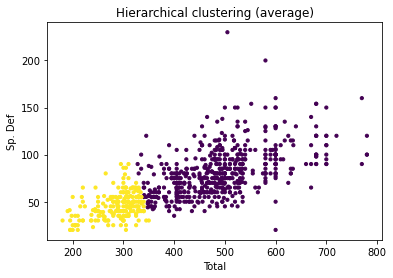

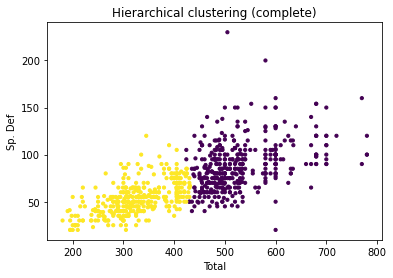

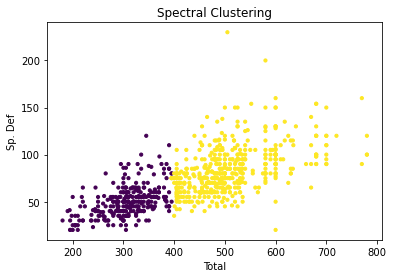

K-MEAN
Homogeneity : 0.196609910250836
Completeness : 0.08874193964958704
V-measure : 0.12228793888022062
Adjusted Rand-Index : 0.004548508290584367
Silhouette Coefficient : 0.21721365107499707 

Clustering(Ward)
Homogeneity : 0.13932785013854251
Completeness : 0.06679546642778939
V-measure : 0.09030000963903762
Adjusted Rand-Index : -0.04912338823485357
Silhouette Coefficient : 0.2165128978225266 

Clustering (Average)
Homogeneity : 0.1060496109455007
Completeness : 0.05542614031595932
V-measure : 0.07280251766348178
Adjusted Rand-Index : -0.07317246501258522
Silhouette Coefficient : 0.2009079182529994 

Clustering (Complete)
Homogeneity : 0.20509187023098974
Completeness : 0.09229828639503
V-measure : 0.12730500828026395
Adjusted Rand-Index : 0.01349366958869755
Silhouette Coefficient : 0.21722715135574241 

Spectral Clustering
Homogeneity : 0.15020465236754418
Completeness : 0.0707089353872466
V-measure : 0.09615353376008165
Adjusted Rand-Index : -0.03996010250042213
Silhouette Coef

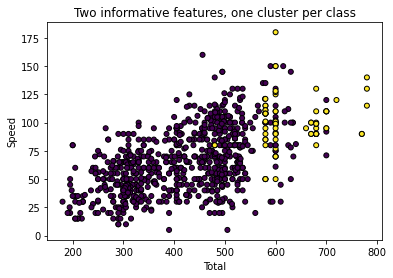

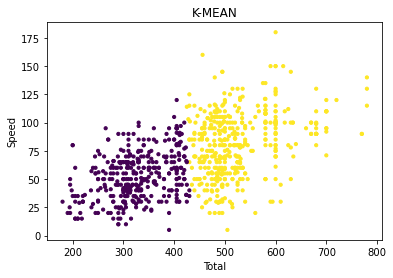

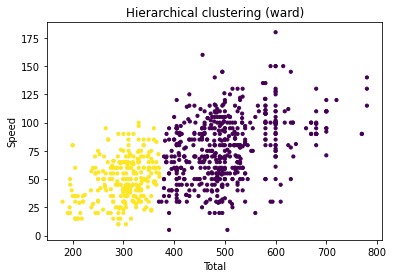

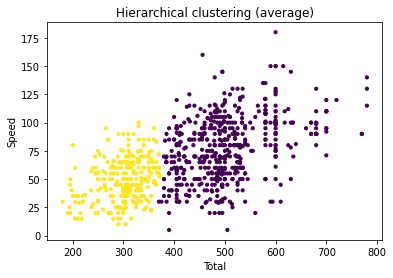

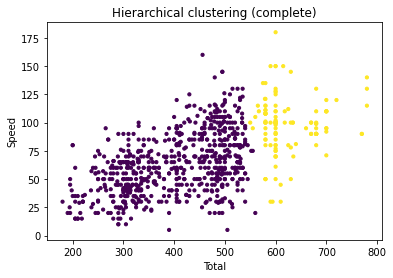

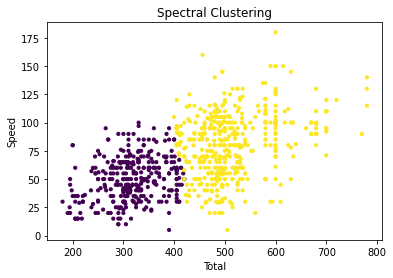

K-MEAN
Homogeneity : 0.20197974046963443
Completeness : 0.09098338622263255
V-measure : 0.12545470103204567
Adjusted Rand-Index : 0.010185490872473993
Silhouette Coefficient : 0.21742063132341435 

Clustering(Ward)
Homogeneity : 0.13434237865218812
Completeness : 0.06503678888733382
V-measure : 0.08764403048570947
Adjusted Rand-Index : -0.05313157348629689
Silhouette Coefficient : 0.21695421206323284 

Clustering (Average)
Homogeneity : 0.13434237865218812
Completeness : 0.06503678888733382
V-measure : 0.08764403048570947
Adjusted Rand-Index : -0.05313157348629689
Silhouette Coefficient : 0.21695421206323284 

Clustering (Complete)
Homogeneity : 0.6488514344049406
Completeness : 0.47757808906516713
V-measure : 0.5501937257036524
Adjusted Rand-Index : 0.6729386087802863
Silhouette Coefficient : 0.18817696864283084 

Spectral Clustering
Homogeneity : 0.1732150843323478
Completeness : 0.07936388712202075
V-measure : 0.10885326139090182
Adjusted Rand-Index : -0.018892642319885248
Silhouett

In [109]:
for feature in ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print(feature)
    km, clusterings, spectral = clustering_by_unsupervised_learning(data, 'Total', feature, 'Legendary')
    evaluation(km, clusterings, spectral)

# DECISIONS TREE

In [117]:
clf = tree.DecisionTreeClassifier()
feature_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
clf = clf.fit(data[feature_int], data['Legendary'])
class_pred_DT = clf.predict(data[feature_int])

In [118]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_int, 
                                class_names=['Not Legendary', 'Legendary'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('Lengendary status')

'Lengendary status.pdf'